Population haplotypes is on: cpu
Trait effects is on: cpu
Trait intercept is on: cpu
Population scores is on: cpu
Variance of scores: 2.0599539279937744
Selected haplotypes is on: cpu
Original population shape: torch.Size([1000, 2, 10000])
Selected haplotypes shape: torch.Size([200, 2, 10000])
Gametes is on: cpu
Gametes shape: torch.Size([1000, 10000])
New population shape: torch.Size([500, 2, 10000])


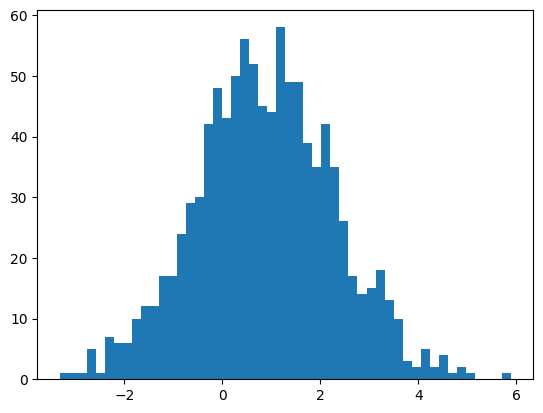

In [1]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt

@dataclass
class SimulationConfig:
    n_markers: int = 1000
    pop_size: int = 1000
    h2: float = 1.0
    selection_intensity: float = 0.2
    
class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.device: torch.device = device
        self.haplotypes: torch.Tensor = torch.randint(0, 2, (pop_size, genome.ploidy, genome.n_markers), 
                                                      dtype=torch.float32, device=self.device)

    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"

class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1.0):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        raw_effects = torch.randn(genome.n_markers, device=self.device)
        centered_effects = raw_effects - raw_effects.mean()

        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"

class SimOps:
    @staticmethod
    def score_population(population: Population, trait: Trait, h2: float = 1.0) -> torch.Tensor:
        dosages = population.haplotypes.sum(dim=1)
        breeding_values = torch.einsum('ij,j->i', dosages, trait.effects) + trait.intercept
        
        bv_var = breeding_values.var()
        if bv_var == 0 or h2 >= 1:
            return breeding_values

        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=population.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        return breeding_values + env_effects


    @staticmethod
    def truncation_selection(population: Population, phenotypes: torch.Tensor, selection_intensity: float) -> torch.Tensor:
        assert 0 < selection_intensity <= 1, "Selection intensity must be between 0 and 1"
        assert population.haplotypes.shape[0] == phenotypes.shape[0], "Mismatch between population size and phenotypes"
        
        num_select = max(1, int(selection_intensity * population.pop_size))
        _, top_indices = torch.topk(phenotypes, num_select)
        return population.haplotypes[top_indices]

    @staticmethod
    def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        num_parents, ploidy, num_markers = selected_haplotypes.shape
        
        # Repeat each parent's haplotypes num_gametes_per_parent times
        expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)
        
        # The rest of the function remains largely the same, but operates on the expanded haplotypes
        total_gametes = num_parents * num_gametes_per_parent
        
        crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device)
        crossover_points, _ = torch.sort(crossover_points, dim=1)
        
        crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
        crossover_mask.scatter_(1, crossover_points, 1)
        crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1
        
        crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)
        
        start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
        start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)
        
        final_mask = crossover_mask ^ start_mask.bool()
        
        offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))
        
        # Return only the first haplotype for each meiosis event
        return offspring_haplotypes[:, 0, :]
    @staticmethod
    def check_cuda(tensor: torch.Tensor, name: str) -> None:
        print(f"{name} is on: {tensor.device}")


    @staticmethod
    def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
        num_gametes, n_markers = gamete_tensor.shape
        
        # Assert that total_crosses is less than half the number of gametes
        assert total_crosses <= num_gametes // 2, f"Total crosses ({total_crosses}) must be less than or equal to half the number of gametes ({num_gametes // 2})"
        
        # Randomly select gametes for crossing
        gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
        parent1_indices = gamete_indices[:total_crosses]
        parent2_indices = gamete_indices[total_crosses:2*total_crosses]
        
        # Create the new population haplotype tensor
        new_population = torch.stack([
            gamete_tensor[parent1_indices],
            gamete_tensor[parent2_indices]
        ], dim=1)
        
        return new_population

##################

class SimParams:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)
        self.population = Population(config.pop_size, self.genome, self.device)
        self.trait = Trait(self.genome, self.population)


    def score_population(self, h2: Optional[float] = None) -> torch.Tensor:
        h2 = h2 if h2 is not None else self.config.h2
        return SimOps.score_population(self.population, self.trait, h2)

    def truncation_selection(self, selection_intensity: Optional[float] = None) -> torch.Tensor:
        selection_intensity = selection_intensity if selection_intensity is not None else self.config.selection_intensity
        phenotypes = self.score_population()
        return SimOps.truncation_selection(self.population, phenotypes, selection_intensity)

    def check_device(self) -> None:
        SimOps.check_cuda(self.population.haplotypes, "Population haplotypes")
        SimOps.check_cuda(self.trait.effects, "Trait effects")
        SimOps.check_cuda(self.trait.intercept, "Trait intercept")

    def to(self, device: torch.device) -> 'SimParams':
        self.device = device
        self.population = self.population.to(device)
        self.trait = self.trait.to(device)
        return self
    def perform_meiosis(self, selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
        return SimOps.meiosis(selected_haplotypes, num_crossovers, num_gametes_per_parent)

    def create_next_generation(self, gametes: torch.Tensor, total_crosses: int) -> None:
        new_population_haplotypes = SimOps.random_cross(gametes, total_crosses)
        self.population.haplotypes = new_population_haplotypes
        self.population.pop_size = total_crosses


########### SIM PARAMS  ^^^^^^^^^^^^^^^^^^^^^^^^^



# Usage
config = SimulationConfig(
    n_markers=10000,
    pop_size=1000,
    h2=0.5,
    selection_intensity=0.2)

SP = SimParams(config)
SP.to(SP.device)  # Ensure all tensors are on the correct device

scores = SP.score_population()

plt.hist(SP.score_population().detach().cpu().numpy(), bins=50)
SP.check_device()
SimOps.check_cuda(scores, "Population scores")

print(f"Variance of scores: {scores.var()}")

selected_haplotypes = SP.truncation_selection()
SimOps.check_cuda(selected_haplotypes, "Selected haplotypes")

print(f"Original population shape: {SP.population.haplotypes.shape}")
print(f"Selected haplotypes shape: {selected_haplotypes.shape}")

# After performing meiosis and generating gametes
gametes = SP.perform_meiosis(selected_haplotypes, num_crossovers=3, num_gametes_per_parent=5)
SimOps.check_cuda(gametes, "Gametes")
print(f"Gametes shape: {gametes.shape}")

# Perform random crosses to create the next generation
total_crosses = min(SP.config.pop_size, gametes.shape[0] // 2)
SP.create_next_generation(gametes, total_crosses)

print(f"New population shape: {SP.population.haplotypes.shape}")


In [2]:
%%timeit
scores_h2_05 = SP.score_population(h2=0.5)  # Equal genetic and environmental variance

3.57 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
%%timeit
gametes = SP.perform_meiosis(selected_haplotypes, num_crossovers=3)

10.7 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit
total_crosses = min(SP.config.pop_size, gametes.shape[0] // 2)
SP.create_next_generation(gametes, total_crosses)

7.63 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
